# Car Price Prediction Project

## Objective
The goal of this notebook is to build and evaluate machine learning models that can accurately predict the sales price of used Toyota cars based on various features such as year, mileage, and specifications.  

## Workflow Overview

1. **Data Preprocessing**

2. **Exploratory Data Analysis (EDA)**

3. **Model Development**

4. **Model Evaluation**

5. **Feature Importance & Business Insights**

6. **Results & Discussion**



## Setup and Configuration

In [2]:
# --- SETUP ---
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

!pip install xgboost
from xgboost import XGBRegressor

import joblib

# --- CONFIG ---
DATA_PATH = "Toyota_car_data.xlsx"  
RANDOM_STATE = 42 # ensures reproducibility of results
CURRENT_YEAR = datetime.now().year 

In [7]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import seaborn as sns
import xgboost
import joblib
import openpyxl
import sys
print(sys.version)


print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", sns.__version__)
print("xgboost:", xgboost.__version__)
print("joblib:", joblib.__version__)
print("openpyxl:", openpyxl.__version__)



3.9.17 (main, Jul  5 2023, 16:05:27) 
[Clang 14.0.6 ]
pandas: 2.1.1
numpy: 1.24.3
scikit-learn: 1.3.1
matplotlib: 3.7.1
seaborn: 0.12.2
xgboost: 2.1.4
joblib: 1.2.0
openpyxl: 3.0.10


## 1) Load & Clean Data

### Purpose
Prepare the raw Toyota dataset by standardizing columns, extracting useful features, and saving a cleaned version for analysis.

### Key Steps
1. **Standardize Columns**:clean names (remove spaces/special chars).  
2. **Numeric Cleaning**: convert `Mileage`, `Engine_Size`, `Seats`, etc. to numeric.  
3. **Feature Extraction**: from `Name`, get `Registration_Year`, `Vehicle_Age`, and `Model`; add `Brand = TOYOTA`.  
4. **Drop Irrelevant Columns**: remove IDs (`Ref_No`, `Chassis_No`, etc.).  
5. **Filter Rows**:keep only valid, positive target values.  
6. **Save Cleaned Data**: export as `result1.xlsx`.



In [2]:
# 1) LOAD & CLEAN

import pandas as pd
import numpy as np
import re
from datetime import datetime

CURRENT_YEAR = datetime.now().year

#Helper functions
def standardize_columns(df):
    df = df.copy()
    df.columns = (
         df.columns.str.strip() # Remove leading/trailing spaces
                  .str.replace(r'\s+', ' ', regex=True) # Replace multiple spaces with a single space
                  .str.replace(' ', '_')               # Replace spaces with underscores
                  .str.replace(r'[^0-9a-zA-Z_]', '', regex=True) # Remove special characters
    )
    return df

def parse_numeric_series(s):
    if s.dtype == object:
        return (
            s.astype(str)                          #all values are strings
             .str.replace(',', '', regex=False)    # Remove commas
             .str.replace(r'[^\d\.\-]', '', regex=True)  # Keep only digits, dot, minus
             .replace({'': np.nan, '-': np.nan})   # Convert empty strings and '-' to NaN
             .astype(float)                        # Convert to float
        )
    else:
        return pd.to_numeric(s, errors='coerce') # For numeric columns, safely convert

# Load dataset 
raw_df = pd.read_excel(DATA_PATH)
df = standardize_columns(raw_df)

# Target Selection 
if 'Discount_Price' in df.columns:
    temp = parse_numeric_series(df['Discount_Price'])
    if temp.notna().sum() > 0:
        df['TargetPrice'] = temp
        target_col = 'TargetPrice'
    else:
        df['TargetPrice'] = parse_numeric_series(df['Original_Price'])
        target_col = 'TargetPrice'
else:
    df['TargetPrice'] = parse_numeric_series(df['Original_Price'])
    target_col = 'TargetPrice'

# Clean numeric-like columns 
num_like_cols = []
for col in ['Mileage','Engine_Size','Seats','Doors','Weight','MaxCap','M3']:
    if col in df.columns:
        df[col] = parse_numeric_series(df[col])
        num_like_cols.append(col)

# Extract registration year, vehicle age, and model from Name 
def extract_year_and_model(df):
    reg_year = []
    model_name = []

    for name in df['Name']:
        if pd.isna(name):
            reg_year.append(np.nan)
            model_name.append(np.nan)
            continue

        # Extract 4-digit year (assume registration year)
        year_match = re.search(r'\b(19|20)\d{2}\b', name)
        year = int(year_match.group()) if year_match else np.nan
        reg_year.append(year)

        # Extract model: everything after 'TOYOTA'
        parts = name.upper().split('TOYOTA')
        if len(parts) > 1:
            model = parts[1].strip()
        else:
            model = np.nan
        model_name.append(model)
        
        
    df['Brand'] = 'TOYOTA'
    df['Registration_Year'] = reg_year
    df['Vehicle_Age'] = [CURRENT_YEAR - y if not pd.isna(y) else np.nan for y in reg_year]
    df['Model'] = model_name

    return df

df = extract_year_and_model(df)

# Candidate features 
candidate_features = [
    'Model','Brand', 'Mileage','Engine_Size','Fuel','Transmission','Vehicle_Age'
    ,'Seats','Doors','Drive','Ext_Color','Steering'
]
if 'Version_Class' in df.columns and 'VersionClass' not in df.columns:
    df['VersionClass'] = df['Version_Class']
features = [c for c in candidate_features if c in df.columns]

# Drop obvious IDs 
drop_cols = [c for c in ['Ref_No','Chassis_No','Engine_Code','Model_Code','Sub_Ref_No'] if c in df.columns]
df = df.drop(columns=drop_cols)

# Drop rows with missing/invalid target 
df = df[df[target_col].notna() & (df[target_col] > 0)].copy()


cleaned_path = "result1.xlsx"
df.to_excel(cleaned_path, index=False)
print(f"Cleaned dataset saved to {cleaned_path}, shape={df.shape}")


Cleaned dataset saved to result1.xlsx, shape=(1313, 27)


In [3]:
# Loading the heads of cleaned dataset 

df = pd.read_excel("result1.xlsx")
df.head()

,Name,Seller,Original_Price,Discount_Price,Mileage,Steering,Engine_Size,Ext_Color,Location,Fuel,...,Dimension,ManufactureYearmonth,Weight,MaxCap,Auction_Grade,TargetPrice,Brand,Registration_Year,Vehicle_Age,Model
0,2014 TOYOTA HARRIER PREMIUM ADVANCED PACKAGE,3rd Party,"10,370","$9,770",142137,Right,1980,Black,KYUSHU,Petrol,...,4.72×1.83×1.69 m,2014/10,1610,NaN,NaN,9770,TOYOTA,2014,11,HARRIER PREMIUM ADVANCED PACKAGE
1,2014 TOYOTA LAND CRUISER PRADO TX L PACKAGE,3rd Party,"18,680","$17,770",135081,Right,2690,Black,NAGOYA,Petrol,...,4.76×1.88×1.85 m,2014/9,2110,NaN,NaN,17770,TOYOTA,2014,11,LAND CRUISER PRADO TX L PACKAGE
2,2018 TOYOTA NOAH X,Be Forward,"8,010","$7,590",165879,Right,1980,Black,NAGOYA,Petrol,...,4.69×1.69×1.82 m,-,1570,NaN,NaN,7590,TOYOTA,2018,7,NOAH X
3,2022 TOYOTA YARIS CROSS G,3rd Party,"12,710","$12,080",34663,Right,1490,Black,OSAKA,Petrol,...,4.18×1.76×1.59 m,-,1120,NaN,NaN,12080,TOYOTA,2022,3,YARIS CROSS G
4,2015 TOYOTA LAND CRUISER ZX,3rd Party,"26,410","$25,230",90145,Right,4600,Maroon,YOKOHAMA,Petrol,...,4.95×1.97×1.91 m,2015/4,2700,NaN,NaN,25230,TOYOTA,2015,10,LAND CRUISER ZX


## 2) Load Cleaned Data & Preprocess

### Purpose
Load the cleaned file, define the target, handle missing values, and set up preprocessing for modeling.

### Key Steps
1. **Load Data**: from `result1.xlsx`.  
2. **Target Column**: use `TargetPrice` if present, else `Discount_Price` / `Original_Price`.  
3. **Feature Selection**: keep relevant numeric & categorical features.  
4. **Missing Values**: median for numeric, mode for categorical.  
5. **Preprocessing**: scale numeric (StandardScaler), one-hot encode categorical (OneHotEncoder).



In [4]:
# 1) LOAD CLEANED DATA

df = pd.read_excel("result1.xlsx")
CURRENT_YEAR = datetime.now().year


# Target column 
if 'TargetPrice' in df.columns:
    df['Target'] = df['TargetPrice']
else:
    def _to_num(s):
        return (
            s.astype(str).str.replace(',', '', regex=False)
             .str.replace(r'[^\d\.\-]', '', regex=True)
             .replace({'': np.nan, '-': np.nan}).astype(float)
        )
    if 'Discount_Price' in df.columns:
        disc = _to_num(df['Discount_Price'])
    else:
        disc = pd.Series([np.nan]*len(df))
    orig = _to_num(df['Original_Price']) if 'Original_Price' in df.columns else pd.Series([np.nan]*len(df))
    df['Target'] = np.where(disc.notna(), disc, orig)

# Keep only valid target rows
df = df[df['Target'].notna() & (df['Target'] > 0)].copy()


# Handle missing values
features = [
    'Model','Brand', 'Mileage','Engine_Size','Fuel','Transmission','Vehicle_Age'
    ,'Seats','Doors','Drive','Ext_Color','Steering'
]

X = df[features].copy()
y = df['Target'].copy()

# Identify numeric & categorical
num_cols = X.select_dtypes(include=['float64','int64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Fill missing values
for col in num_cols:
    X[col] = X[col].fillna(X[col].median())

for col in cat_cols:
    X[col] = X[col].fillna(X[col].mode()[0])



# Encode categorical variables + scaling

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

# Fit transformer to the whole X (for inspection)
preprocessor.fit(X)

print("Preprocessing done.")

Preprocessing done.


## 3) Exploratory Data Analysis (EDA)

### Purpose
Explore the cleaned dataset to understand target distribution, relationships between key features and price, and correlations among variables.

### Key Steps
1. **Target Distribution**: histogram with KDE to check car price spread.  
2. **Scatter Plots**: visualize how `Mileage`, `Engine_Size`, and `Vehicle_Age` affect price.  
3. **Correlation Matrix**: heatmap of numeric features + target to identify strong/weak relationships.


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


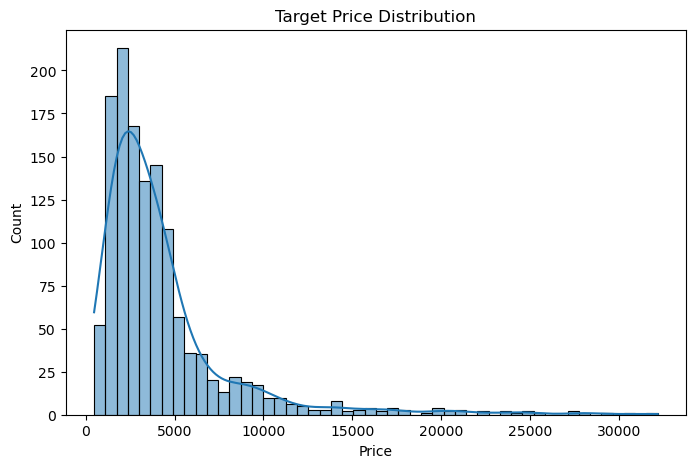

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


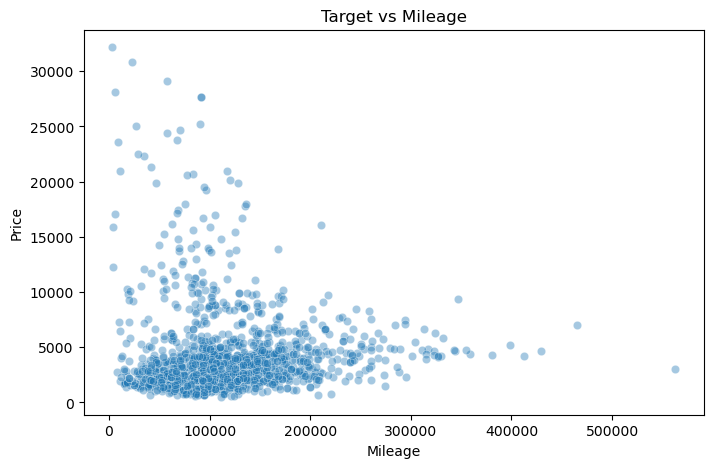

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


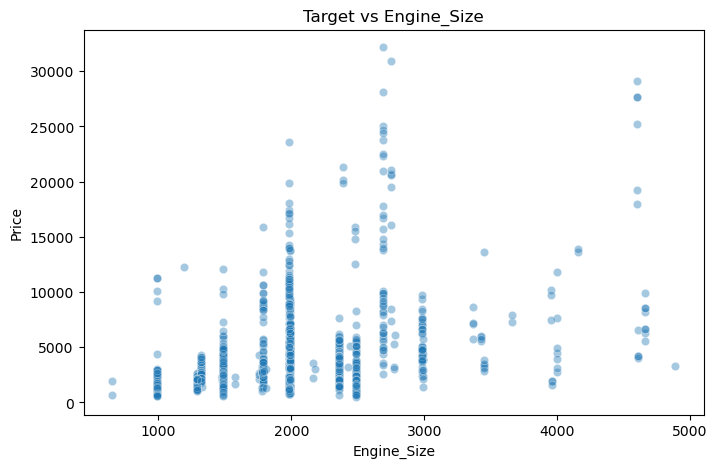

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


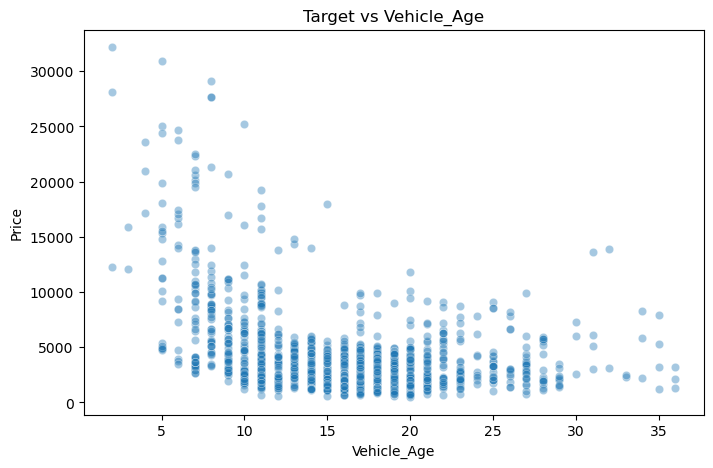

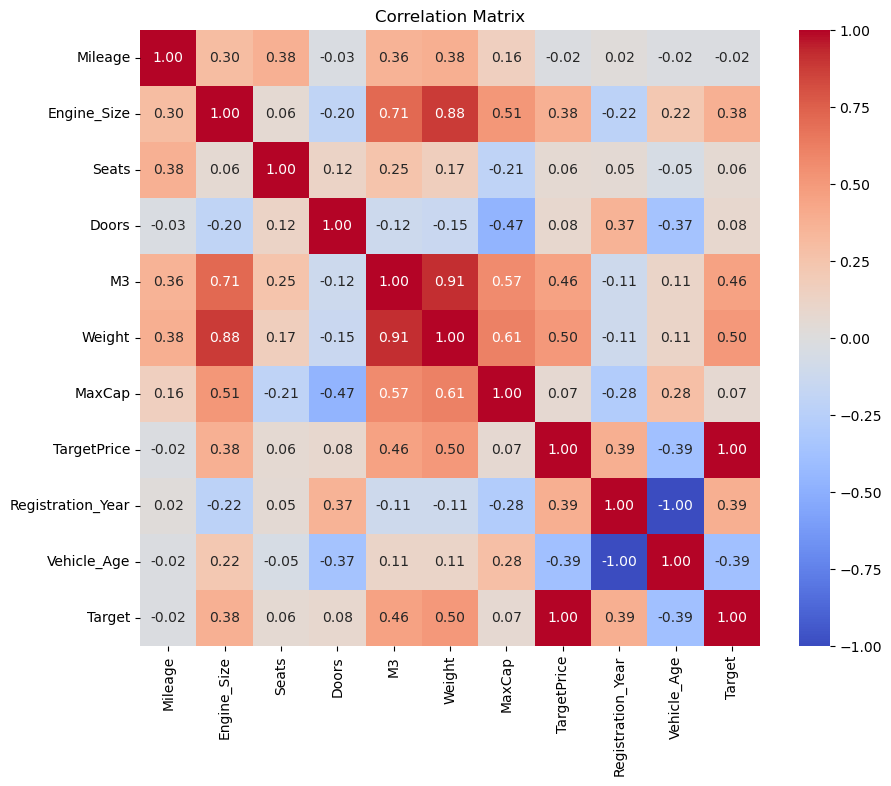

In [6]:
# 2) EXPLORATORY DATA ANALYSIS (EDA)

import seaborn as sns
import matplotlib.pyplot as plt

# Ensure target exists
if 'Target' not in df.columns:
    if 'TargetPrice' in df.columns:
        df['Target'] = df['TargetPrice']
    else:
        df['Target'] = pd.to_numeric(df['Original_Price'], errors='coerce')


# Target distribution
plt.figure(figsize=(8,5))
sns.histplot(df['Target'], bins=50, kde=True)
plt.title("Target Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()


# Scatter plots for key numeric features
numeric_features = ['Mileage','Engine_Size','Vehicle_Age']
for col in numeric_features:
    if col in df.columns:
        plt.figure(figsize=(8,5))
        sns.scatterplot(x=df[col], y=df['Target'], alpha=0.4)
        plt.title(f'Target vs {col}')
        plt.xlabel(col)
        plt.ylabel("Price")
        plt.show()


# Correlation matrix for numeric features
numeric_cols = df.select_dtypes(include=['float64','int64']).columns.tolist()

# Only features + target
corr_cols = [c for c in numeric_cols if c in df.columns]  
if 'Target' not in corr_cols:
    corr_cols.append('Target')

plt.figure(figsize=(10,8))
sns.heatmap(df[corr_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()



## 4) Model Development

### Purpose
Train and evaluate multiple regression models to predict car prices and analyze feature importance.

### Key Steps
1. **Train/Test Split**: 80% training, 20% testing.  
2. **Models Trained**  
   - Linear Regression 
   - Random Forest Regressor 
   - XGBoost Regressor   
3. **Pipeline**: preprocessing (scaling + encoding) + regression model.  
4. **Evaluation Metrics**: RMSE, MAE, R² for test set predictions.  
5. **Feature Importance**: for tree-based models (Random Forest & XGBoost), top 20 features visualized.



Linear Regression Evaluation:
RMSE: 41349860759717.38
MAE: 12852118592739.25
R²: -128041260513568014336.0000

Random Forest Evaluation:
RMSE: 1398.68
MAE: 796.58
R²: 0.8535


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


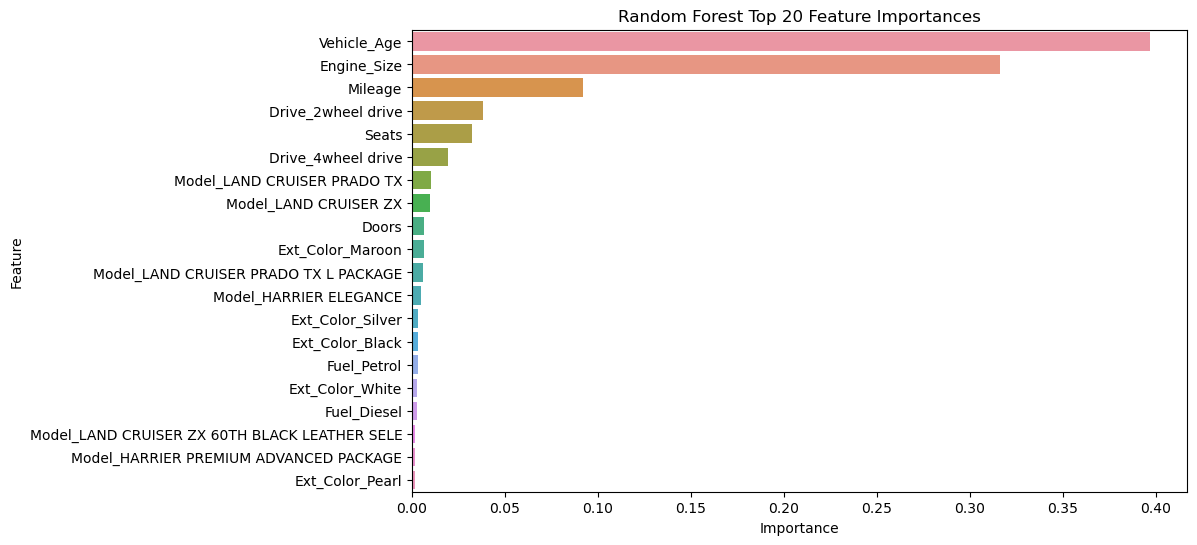


XGBoost Evaluation:
RMSE: 1319.50
MAE: 737.39
R²: 0.8696


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


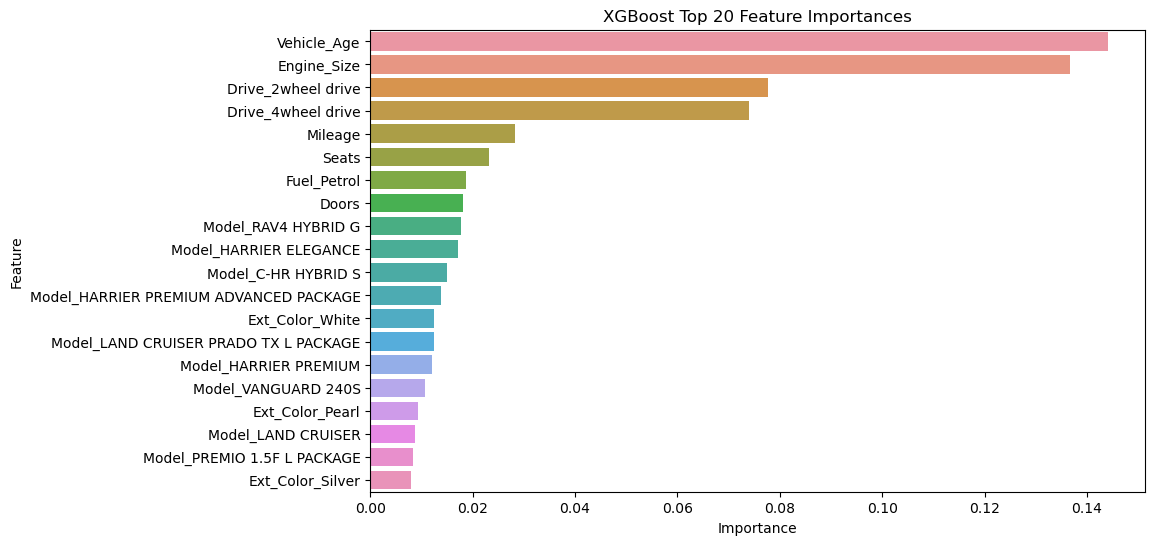


=== Model Performance Summary ===


,Model,RMSE,MAE,R2
2,XGBoost,1.319496e+03,7.373932e+02,8.696180e-01
1,Random Forest,1.398682e+03,7.965819e+02,8.534993e-01
0,Linear Regression,4.134986e+13,1.285212e+13,-1.280413e+20


In [7]:
# 3) MODEL DEVELOPMENT

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=RANDOM_STATE)
}


# Train, evaluate, and store results
results = []

for name, model in models.items():
    # Build pipeline: preprocessing + model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Fit model
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    
    # Metrics
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })
    
    print(f"\n{name} Evaluation:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")
    
    # Feature importance for tree-based models
    if name in ["Random Forest", "XGBoost"]:
        # feature names after preprocessing
        feature_names_num = num_cols
        feature_names_cat = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_cols)
        feature_names = np.concatenate([feature_names_num, feature_names_cat])
        
        # importance
        importances = pipeline.named_steps['regressor'].feature_importances_
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)
        
        # Plot
        plt.figure(figsize=(10,6))
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title(f"{name} Top 20 Feature Importances")
        plt.show()

results_df = pd.DataFrame(results)
print("\n=== Model Performance Summary ===")
display(results_df.sort_values(by='R2', ascending=False))


## 5) Cross-Validation

### Purpose
Evaluate model performance more reliably using k-fold cross-validation to account for variability in train/test splits.

### Key Steps
1. **Pipeline**: preprocessing + regression model for each algorithm.  
2. **5-Fold CV**: calculate metrics across 5 folds:  
   - **RMSE** (Root Mean Squared Error)  
   - **R²** (Coefficient of Determination)  
3. **Results Aggregation**: store mean and standard deviation for each metric.


In [8]:
from sklearn.model_selection import cross_val_score

cv_results = []

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # RMSE (neg_mean_squared_error)
    neg_mse_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-neg_mse_scores)
    
    # R²
    r2_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
    
    cv_results.append({
        "Model": name,
        "RMSE Mean": rmse_scores.mean(),
        "RMSE Std": rmse_scores.std(),
        "R2 Mean": r2_scores.mean(),
        "R2 Std": r2_scores.std()
    })

cv_results_df = pd.DataFrame(cv_results)
print("\n=== Cross-Validation Results ===")
display(cv_results_df)



=== Cross-Validation Results ===


,Model,RMSE Mean,RMSE Std,R2 Mean,R2 Std
0,Linear Regression,1.549911e+14,1.375855e+14,-2.896927e+21,3.394883e+21
1,Random Forest,1.396760e+03,4.052463e+02,8.626146e-01,2.414185e-02
2,XGBoost,1.398029e+03,4.052037e+02,8.590565e-01,3.817240e-02


## 6) Fit Models on Full Data & Save Predictions

### Purpose
Train all models on the entire dataset to generate predictions for comparison and export results.

### Key Steps
1. **Pipeline**: preprocessing + regression model for each algorithm.  
2. **Fit on Full Data**: models trained using all available features and target values.  
3. **Predict Prices**: generate predictions for each model on the same dataset.  
4. **Compute Accuracy**: RMSE, MAE, R² on full dataset.  
5. **Save Predictions**: export actual vs predicted prices 

In [9]:
# 1) Fit all models on full data

all_predictions = pd.DataFrame()
all_predictions['Actual_Price'] = y.values  # actual target

for name, model in models.items():
    # Build pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Fit on full dataset
    pipeline.fit(X, y)
    
    # Predict 
    y_pred = pipeline.predict(X)
    
    # Store predictions
    all_predictions[f'{name}_Predicted'] = y_pred
    
    # Accuracy metrics
    rmse = mean_squared_error(y, y_pred, squared=False)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    print(f"\n{name} Accuracy on full dataset:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")

# 2) Save predicted prices to CSV
all_predictions.to_csv("predicted_prices_comparison.csv", index=False)
print("\nAll predictions saved to 'predicted_prices_comparison.csv'.")



Linear Regression Accuracy on full dataset:
RMSE: 985.59
MAE: 513.04
R²: 0.9377

Random Forest Accuracy on full dataset:
RMSE: 473.32
MAE: 273.34
R²: 0.9856

XGBoost Accuracy on full dataset:
RMSE: 537.34
MAE: 416.78
R²: 0.9815

All predictions saved to 'predicted_prices_comparison.csv'.


## 7) Save Final Model Pipeline

### Purpose
Save the best-performing model pipeline for future use without retraining.

In [10]:
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', models['Random Forest'])
])

# Fit on full data
pipeline_rf.fit(X, y)

import joblib

# Save the Random Forest pipeline
joblib.dump(pipeline_rf, 'car_price_predictor.joblib')
print("Random Forest pipeline saved.")

Random Forest pipeline saved.


## 8) Discussion & Report

### Feature Importance Insights
- **Top Contributing Features**: Mileage, Vehicle Age, Engine Size, Model, Transmission.  
- **Business Interpretation**:
  - **Mileage & Age**: Lower mileage and newer cars command higher prices—guides inventory prioritization.  
  - **Engine Size & Model**: Popular or high-performance models fetch premium prices—useful for targeted marketing.  
  - **Transmission**: Manual vs automatic affects resale value—inform customer recommendations.

### Proposed Improvements for Model Accuracy
- More data: larger and diverse datasets improve accuracy.  
- Data augmentation: include accident history, service records, fuel efficiency.  
- External data: market trends, regional pricing, competitor prices. 

### Outcome
- Key features driving car price predictions are identified and interpretable from a business perspective.  
- Suggestions above can further enhance model accuracy and provide actionable insights for pricing, inventory, and customer strategies.